# The goal of thos project is t use the NYC school datasets publicly available __[Here](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)__ to identify the major drivers of high average SAT scores among schools.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

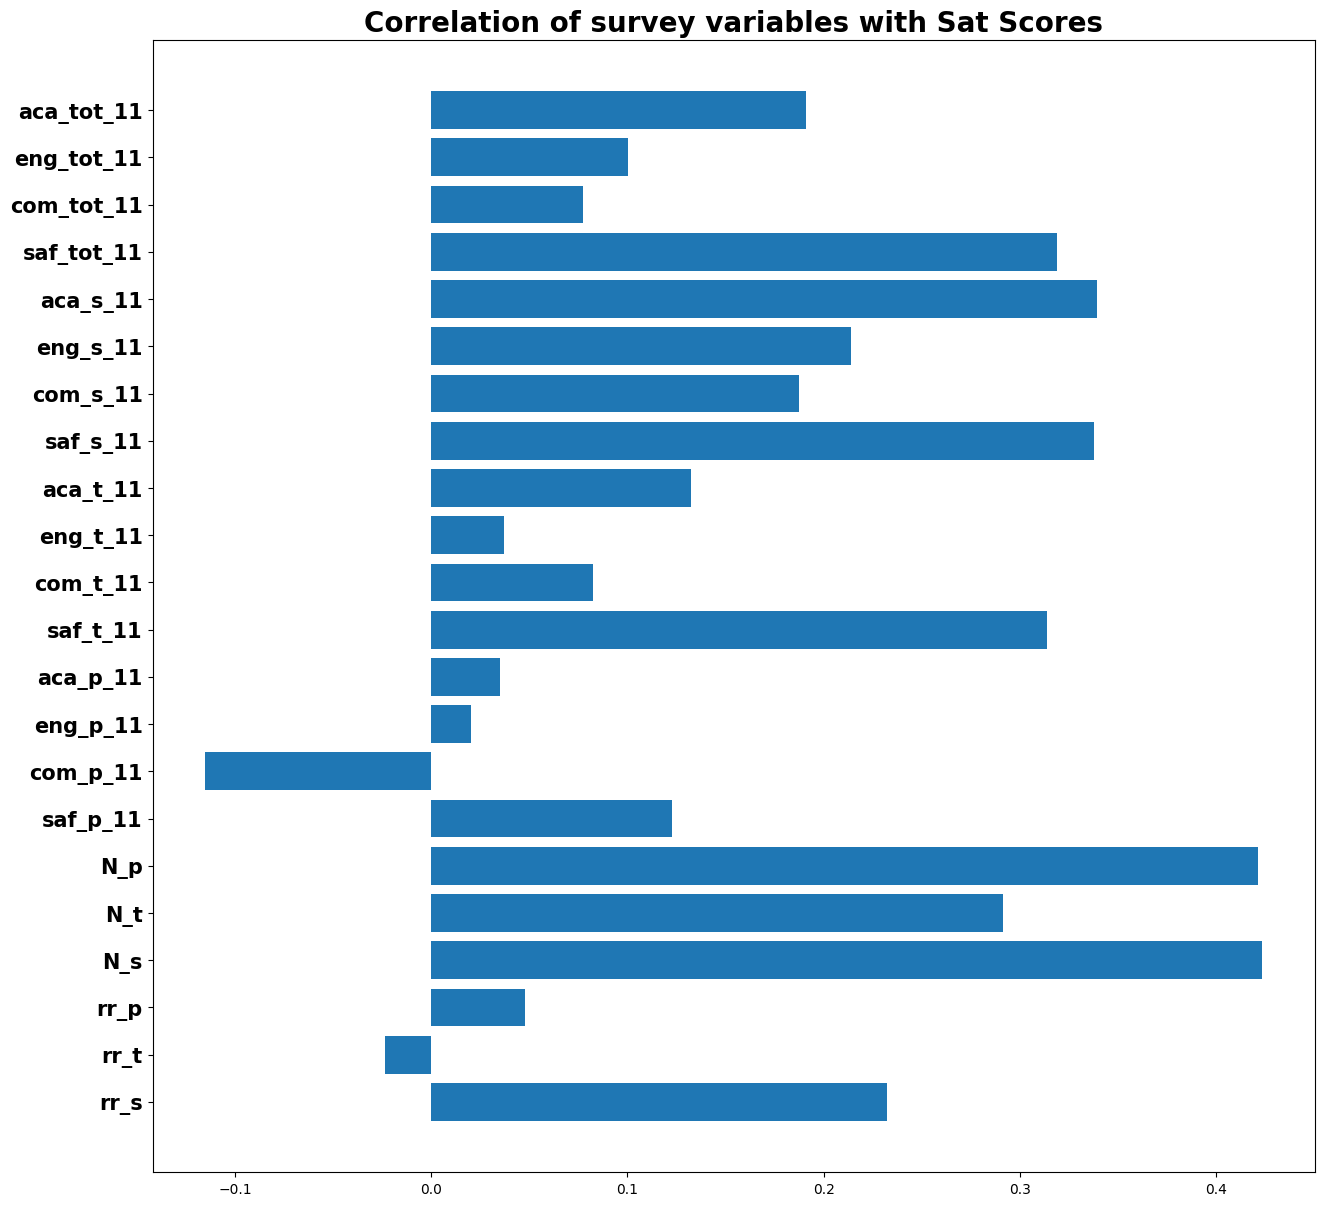

In [33]:
import matplotlib.pyplot as plt
correlations.sort_index(inplace=True)
%matplotlib inline
plt.figure(figsize=(15,15))
plt.barh(correlations[survey_fields].index, correlations[survey_fields])
plt.yticks(correlations[survey_fields].index, fontsize=15, weight='bold')
plt.title('Correlation of survey variables with Sat Scores', fontsize=(20), weight='bold')
plt.show()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## Exploring Safety

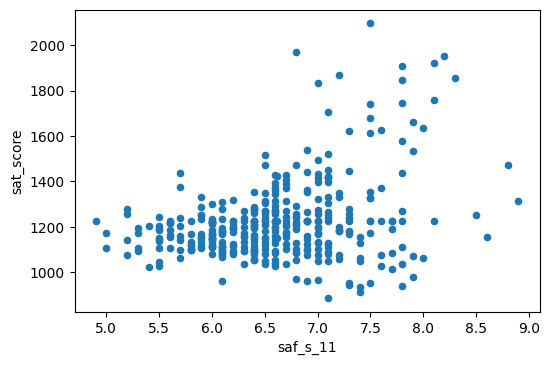

In [34]:
combined.plot(kind='scatter', x='saf_s_11', y = 'sat_score')

It seems that there is a indicative relationship between safety and sat scores. schools with high sat scores have high safety scores. schools with safety scores below 6.5 do not have sat scores above 1500.

In [43]:
borough = combined.groupby('boro').mean()
borough ['saf_s_11']


boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

Text(0.5, 1.0, 'SAT Score Correlation to race')

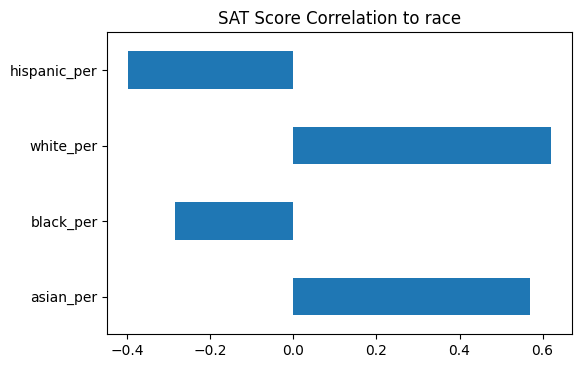

In [45]:
racial_groups = ['asian_per', 'black_per', 'white_per', 'hispanic_per']
correlations[racial_groups].plot(kind='barh')
plt.title('SAT Score Correlation to race')

It seems that hispanic_per school is the most negativly correlated with SAT scores. and vice versa for White_per school.
Ill look into schools with large hispanic_per.

([<matplotlib.axis.XTick at 0x7ff7fff783d0>,
 <a list of 11 Text major ticklabel objects>)

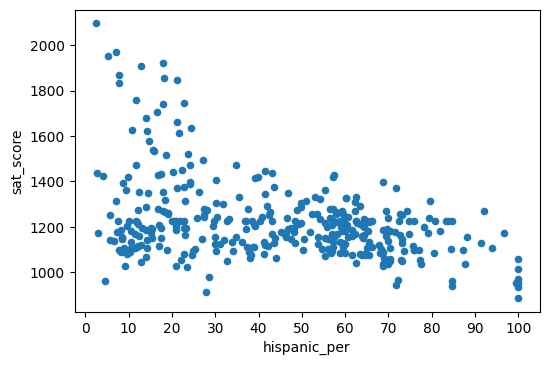

In [49]:
import numpy as np
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.xticks(np.arange(0,110,10))

A negative relationship exists between hispanics_per school and sat_scores.
schools with lower # of hispanics show higher Sat scores.
schools with more than 90% hispanics donot show scores above 1300. this maybe due to funding for schools.

In [50]:
hispanic_schools = combined[combined.hispanic_per>95]
hispanic_schools['School Name']

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Text(0, 0.5, 'English language learner percentage')

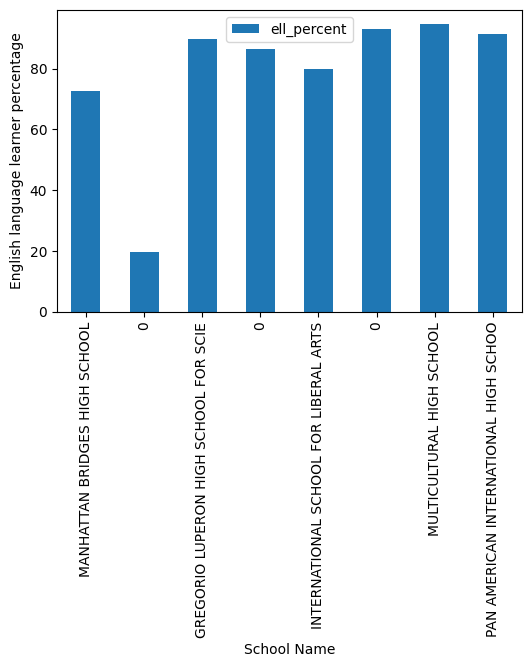

In [56]:
hispanic_schools.plot(kind='bar', x='School Name', y='ell_percent')
plt.ylabel('English language learner percentage')

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [61]:
non_hisp_schools = combined[(combined.hispanic_per<10) & (combined.sat_score>1800)]
non_hisp_schools['School Name']

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

Text(0, 0.5, 'English language learner percentage')

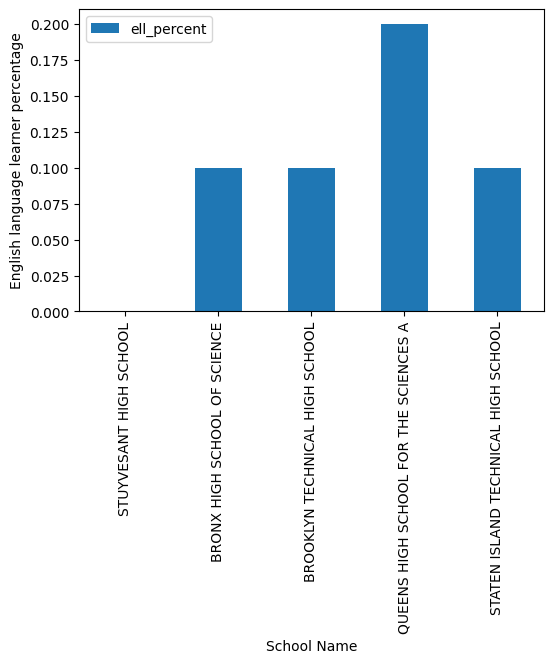

In [62]:
non_hisp_schools.plot(kind='bar', x='School Name', y='ell_percent')
plt.ylabel('English language learner percentage')

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

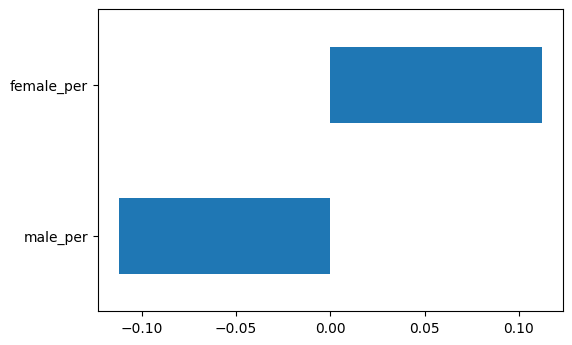

In [63]:
correlations[['male_per', 'female_per']].plot(kind='barh')

There seems to be very slight correlation between gender and SAT scores but its below 0.15 and not worth investigating.

## AP Exam Scores vs SAT Scores

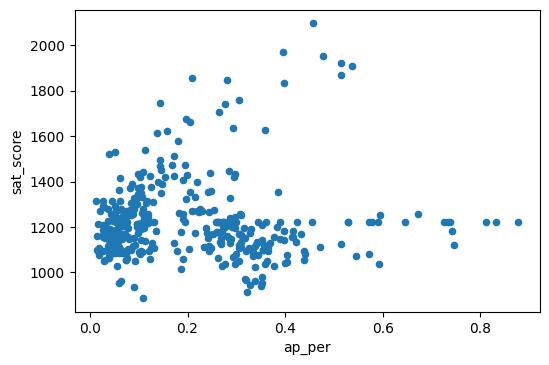

In [64]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores.